# Downloading File

In [8]:
# import os
# import zipfile
# import requests
# from urllib.parse import urlparse

# # URL of the zip file
# url = "https://zenodo.org/records/15624741/files/Archive.zip?download=1"

# # Download the file
# print("Downloading file...")
# response = requests.get(url, stream=True)
# response.raise_for_status()

# # Save the file
# filename = "Archive.zip"
# with open(filename, 'wb') as f:
#     for chunk in response.iter_content(chunk_size=8192):
#         f.write(chunk)

# print(f"Downloaded {filename} ({os.path.getsize(filename)} bytes)")

# # Unzip the file
# print("Extracting files...")
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall(".")

#     # List the extracted files
#     extracted_files = zip_ref.namelist()
#     print(f"Extracted {len(extracted_files)} files:")
#     for file in extracted_files[:10]:  # Show first 10 files
#         print(f"  - {file}")
#     if len(extracted_files) > 10:
#         print(f"  ... and {len(extracted_files) - 10} more files")

# # Clean up the zip file (optional)
# os.remove(filename)
# print(f"Removed {filename}")

# print("Done!")

# Data Loading

In [9]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

In [10]:
def filepath(dir, i):
  return f"./small_images/{dir}/{i}.tif"

In [11]:
def load_tiff_pil(filepath):
    """Load TIFF file using PIL/Pillow"""
    try:
        # Open the TIFF file
        img = Image.open(filepath)

        # Convert to numpy array
        img_array = np.array(img)

        print(f"Image shape: {img_array.shape}")
        print(f"Image dtype: {img_array.dtype}")
        print(f"Image mode: {img.mode}")

        return img_array, img
    except Exception as e:
        print(f"Error loading TIFF: {e}")
        return None, None

In [12]:
def display_tiff(img_array, title="TIFF Image"):
    """Display TIFF image using matplotlib"""
    plt.figure(figsize=(10, 8))

    if len(img_array.shape) == 2:  # Grayscale
        plt.imshow(img_array, cmap='gray')
    else:  # Color
        plt.imshow(img_array)

    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [13]:
def display_noisy_gt_parallel(noisy_img, gt_img, image_idx, figsize=(15, 6)):
    """Display noisy and GT images side by side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Display noisy image
    if len(noisy_img.shape) == 2:  # Grayscale
        im1 = ax1.imshow(noisy_img)
    else:  # Color
        im1 = ax1.imshow(noisy_img)
    ax1.set_title(f"Noisy - Image {image_idx}")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1)

    # Display GT image
    if len(gt_img.shape) == 2:  # Grayscale
        im2 = ax2.imshow(gt_img)
    else:  # Color
        im2 = ax2.imshow(gt_img)
    ax2.set_title(f"Ground Truth - Image {image_idx}")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()

In [14]:
def load_and_display_range(noisy_filepath_pattern, gt_filepath_pattern, start_idx=1000, num_images=10):
    """Load and display noisy and GT images for a specific range"""

    for i in range(num_images):
        current_idx = start_idx + i

        # Format file paths (assuming pattern like "image_{idx}.tiff")
        noisy_path = noisy_filepath_pattern.format(current_idx)
        gt_path = gt_filepath_pattern.format(current_idx)

        print(f"Loading image {current_idx}...")
        print(f"Noisy: {noisy_path}")
        print(f"GT: {gt_path}")

        # Load noisy image
        noisy_array, _ = load_tiff_pil(noisy_path)

        # Load GT image
        gt_array, _ = load_tiff_pil(gt_path)

        if noisy_array is not None and gt_array is not None:
            display_noisy_gt_parallel(noisy_array, gt_array, current_idx)
        else:
            print(f"Failed to load image {current_idx}")
            if noisy_array is None:
                print(f"  - Could not load noisy image: {noisy_path}")
            if gt_array is None:
                print(f"  - Could not load GT image: {gt_path}")


In [15]:
print("\nLoading range of noisy and GT images...")

noisy_pattern = "./large_images/noisy/{}.tif"  # e.g., "noisy/img_{}.tiff"
gt_pattern = "./large_images/gt/{}.tif"        # e.g., "gt/img_{}.tiff"

# Load and display images from 1800 to 1809
# load_and_display_range(
#     noisy_filepath_pattern=noisy_pattern,
#     gt_filepath_pattern=gt_pattern,
#     start_idx=1000,
#     num_images=10
# )


Loading range of noisy and GT images...


In [16]:
# !ls small_images/noisy (1000 - 3456)

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [18]:
def check_alignment_tiff(noisy_array, gt_array):
    # Visual difference check
    diff = np.abs(noisy_array.astype(float) - gt_array.astype(float))

    # Convert to PIL for display
    if len(diff.shape) == 3:
        diff_normalized = (diff / diff.max() * 255).astype(np.uint8)
        diff_img = Image.fromarray(diff_normalized)
    else:
        diff_normalized = (diff / diff.max() * 255).astype(np.uint8)
        diff_img = Image.fromarray(diff_normalized, mode='L')

    diff_img.show()  # or diff_img.save('difference.png')

    # SSIM check
    if len(noisy_array.shape) == 3:
        ssim_score = ssim(noisy_array, gt_array, channel_axis=2)
    else:
        ssim_score = ssim(noisy_array, gt_array)

    print(f"SSIM: {ssim_score:.4f}")  # Should be > 0.3 for aligned images

    # Edge correlation check
    def rgb_to_gray(img_array):
        if len(img_array.shape) == 3:
            return np.dot(img_array[...,:3], [0.2989, 0.5870, 0.1140])
        return img_array

    gray_noisy = rgb_to_gray(noisy_array.astype(float))
    gray_clean = rgb_to_gray(gt_array.astype(float))

    # Simple edge detection
    def simple_edges(img):
        dy, dx = np.gradient(img)
        return np.sqrt(dx**2 + dy**2)

    edges_noisy = simple_edges(gray_noisy)
    edges_clean = simple_edges(gray_clean)

    edge_correlation = np.corrcoef(edges_noisy.flatten(), edges_clean.flatten())[0,1]
    print(f"Edge correlation: {edge_correlation:.4f}")  # Should be > 0.7

    return ssim_score, edge_correlation

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from scipy import stats
import seaborn as sns
import os

def check_alignment_tiff_with_graphs(noisy_array, gt_array, save_plots=False, plot_prefix="alignment"):
    """
    Comprehensive alignment check with detailed graph analysis

    Parameters:
    - noisy_array: numpy array of noisy image
    - gt_array: numpy array of ground truth image
    - save_plots: bool, whether to save plots to disk
    - plot_prefix: string, prefix for saved plot filenames

    Returns:
    - dict with all metrics and analysis results
    """

    # Ensure same data type for comparison
    noisy_float = noisy_array.astype(float)
    gt_float = gt_array.astype(float)

    # Initialize results dictionary
    results = {}

    # 1. VISUAL DIFFERENCE ANALYSIS
    diff = np.abs(noisy_float - gt_float)
    diff_normalized = (diff / diff.max() * 255).astype(np.uint8) if diff.max() > 0 else diff.astype(np.uint8)

    # 2. SSIM CALCULATION
    # Determine data range based on original dtype
    if noisy_array.dtype == np.uint8:
        data_range = 255
    elif noisy_array.dtype == np.uint16:
        data_range = 65535
    else:
        data_range = noisy_array.max() - noisy_array.min()

    if len(noisy_array.shape) == 3:
        ssim_score = ssim(noisy_array, gt_array, channel_axis=2, data_range=data_range)
        ssim_map = ssim(noisy_array, gt_array, channel_axis=2, data_range=data_range, full=True)[1]
    else:
        ssim_score, ssim_map = ssim(noisy_array, gt_array, data_range=data_range, full=True)

    results['ssim'] = ssim_score

    # 3. EDGE CORRELATION ANALYSIS
    def rgb_to_gray(img_array):
        if len(img_array.shape) == 3:
            return np.dot(img_array[...,:3], [0.2989, 0.5870, 0.1140])
        return img_array

    def simple_edges(img):
        dy, dx = np.gradient(img)
        return np.sqrt(dx**2 + dy**2)

    gray_noisy = rgb_to_gray(noisy_float)
    gray_gt = rgb_to_gray(gt_float)

    edges_noisy = simple_edges(gray_noisy)
    edges_gt = simple_edges(gray_gt)

    edge_correlation = np.corrcoef(edges_noisy.flatten(), edges_gt.flatten())[0,1]
    results['edge_correlation'] = edge_correlation

    # 4. PIXEL INTENSITY CORRELATION
    pixel_correlation = np.corrcoef(gray_noisy.flatten(), gray_gt.flatten())[0,1]
    results['pixel_correlation'] = pixel_correlation

    # 5. STATISTICAL ANALYSIS
    mae = np.mean(np.abs(gray_noisy - gray_gt))  # Mean Absolute Error
    mse = np.mean((gray_noisy - gray_gt)**2)     # Mean Squared Error

    # Calculate PSNR properly for the data range
    max_pixel_value = data_range
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse)) if mse > 0 else float('inf')

    results['mae'] = mae
    results['mse'] = mse
    results['psnr'] = psnr

    # CREATE COMPREHENSIVE VISUALIZATION
    fig = plt.figure(figsize=(20, 16))

    # Plot 1: Original images side by side
    ax1 = plt.subplot(4, 4, 1)
    if len(noisy_array.shape) == 3:
        # For color images
        display_noisy = noisy_array
        if noisy_array.dtype == np.uint16:
            display_noisy = (noisy_array / 65535 * 255).astype(np.uint8)
        plt.imshow(display_noisy)
    else:
        # For grayscale images - normalize to 0-1 range for proper display
        display_noisy = noisy_array.astype(float) / data_range
        plt.imshow(display_noisy, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Noisy Image\nRange: [{noisy_array.min()}-{noisy_array.max()}]')
    plt.axis('off')

    ax2 = plt.subplot(4, 4, 2)
    if len(gt_array.shape) == 3:
        display_gt = gt_array
        if gt_array.dtype == np.uint16:
            display_gt = (gt_array / 65535 * 255).astype(np.uint8)
        plt.imshow(display_gt)
    else:
        # For grayscale images - normalize to 0-1 range for proper display
        display_gt = gt_array.astype(float) / data_range
        plt.imshow(display_gt, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Ground Truth\nRange: [{gt_array.min()}-{gt_array.max()}]')
    plt.axis('off')

    # Plot 3: Difference image
    ax3 = plt.subplot(4, 4, 3)
    if len(diff.shape) == 3:
        plt.imshow(diff_normalized)
    else:
        plt.imshow(diff_normalized, cmap='hot')
    plt.title(f'Absolute Difference\nMAE: {mae:.2f}')
    plt.axis('off')

    # Plot 4: SSIM map
    ax4 = plt.subplot(4, 4, 4)
    plt.imshow(ssim_map, cmap='RdYlBu', vmin=0, vmax=1)
    plt.title(f'SSIM Map\nOverall SSIM: {ssim_score:.4f}')
    plt.colorbar()
    plt.axis('off')

    # Plot 5: Pixel intensity scatter plot
    ax5 = plt.subplot(4, 4, 5)
    # Sample pixels for performance
    sample_size = min(10000, noisy_float.size)
    idx = np.random.choice(noisy_float.size, sample_size, replace=False)
    noisy_sample = noisy_float.flatten()[idx]
    gt_sample = gt_float.flatten()[idx]

    plt.scatter(gt_sample, noisy_sample, alpha=0.5, s=1)
    plt.plot([gt_sample.min(), gt_sample.max()], [gt_sample.min(), gt_sample.max()], 'r--', alpha=0.8)
    plt.xlabel('Ground Truth Intensity')
    plt.ylabel('Noisy Intensity')
    plt.title(f'Pixel Correlation: {pixel_correlation:.4f}')
    plt.grid(True, alpha=0.3)

    # Plot 6: Intensity histograms
    ax6 = plt.subplot(4, 4, 6)
    plt.hist(gray_noisy.flatten(), bins=50, alpha=0.7, label='Noisy', density=True)
    plt.hist(gray_gt.flatten(), bins=50, alpha=0.7, label='Ground Truth', density=True)
    plt.xlabel('Intensity')
    plt.ylabel('Density')
    plt.title('Intensity Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 7: Edge strength comparison
    ax7 = plt.subplot(4, 4, 7)
    plt.scatter(edges_gt.flatten()[::100], edges_noisy.flatten()[::100], alpha=0.6, s=1)
    plt.xlabel('GT Edge Strength')
    plt.ylabel('Noisy Edge Strength')
    plt.title(f'Edge Correlation: {edge_correlation:.4f}')
    plt.grid(True, alpha=0.3)

    # Plot 8: Edge images
    ax8 = plt.subplot(4, 4, 8)
    edge_diff = np.abs(edges_noisy - edges_gt)
    plt.imshow(edge_diff, cmap='hot')
    plt.title('Edge Difference')
    plt.colorbar()
    plt.axis('off')

    # Plot 9: Difference histogram
    ax9 = plt.subplot(4, 4, 9)
    diff_flat = diff.flatten()
    plt.hist(diff_flat, bins=50, alpha=0.7, density=True)
    plt.xlabel('Absolute Difference')
    plt.ylabel('Density')
    plt.title(f'Difference Distribution\nStd: {np.std(diff_flat):.2f}')
    plt.grid(True, alpha=0.3)

    # Plot 10: Local SSIM variation
    ax10 = plt.subplot(4, 4, 10)
    # Calculate SSIM in patches
    patch_size = 64
    h, w = gray_noisy.shape
    local_ssims = []
    positions = []

    for i in range(0, h-patch_size, patch_size//2):
        for j in range(0, w-patch_size, patch_size//2):
            patch_noisy = gray_noisy[i:i+patch_size, j:j+patch_size]
            patch_gt = gray_gt[i:i+patch_size, j:j+patch_size]
            if patch_noisy.size > 0 and patch_gt.size > 0:
                local_ssim = ssim(patch_noisy, patch_gt, data_range=data_range)
                local_ssims.append(local_ssim)
                positions.append((i+patch_size//2, j+patch_size//2))

    local_ssims = np.array(local_ssims)
    plt.hist(local_ssims, bins=30, alpha=0.7)
    plt.xlabel('Local SSIM')
    plt.ylabel('Frequency')
    plt.title(f'Local SSIM Distribution\nMean: {np.mean(local_ssims):.3f}')
    plt.grid(True, alpha=0.3)

    results['local_ssim_mean'] = np.mean(local_ssims)
    results['local_ssim_std'] = np.std(local_ssims)

    # Plot 11: Residual analysis
    ax11 = plt.subplot(4, 4, 11)
    residual = noisy_float - gt_float
    plt.imshow(residual, cmap='RdBu', vmin=-np.max(np.abs(residual)), vmax=np.max(np.abs(residual)))
    plt.title('Residual (Noisy - GT)')
    plt.colorbar()
    plt.axis('off')

    # Plot 12: Quality metrics summary
    ax12 = plt.subplot(4, 4, 12)
    metrics = ['SSIM', 'Edge Corr', 'Pixel Corr', 'PSNR/40']
    values = [ssim_score, edge_correlation, pixel_correlation, min(psnr/40, 1)]
    colors = ['green' if v > 0.8 else 'orange' if v > 0.5 else 'red' for v in values[:3]]
    colors.append('green' if psnr > 30 else 'orange' if psnr > 20 else 'red')

    bars = plt.bar(metrics, values, color=colors, alpha=0.7)
    plt.ylim(0, 1)
    plt.title('Alignment Quality Metrics')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, value in zip(bars, [ssim_score, edge_correlation, pixel_correlation, psnr]):
        if bar == bars[-1]:  # PSNR bar
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{value:.1f}dB', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)

    # Plot 13-16: Channel-wise analysis for color images
    if len(noisy_array.shape) == 3 and noisy_array.shape[2] >= 3:
        channel_names = ['Red', 'Green', 'Blue']
        for i in range(3):
            ax = plt.subplot(4, 4, 13 + i)
            channel_corr = np.corrcoef(noisy_array[:,:,i].flatten(), gt_array[:,:,i].flatten())[0,1]
            plt.scatter(gt_array[:,:,i].flatten()[::1000], noisy_array[:,:,i].flatten()[::1000],
                       alpha=0.5, s=1, c=channel_names[i].lower())
            plt.xlabel(f'GT {channel_names[i]}')
            plt.ylabel(f'Noisy {channel_names[i]}')
            plt.title(f'{channel_names[i]} Correlation: {channel_corr:.4f}')
            plt.grid(True, alpha=0.3)

            results[f'channel_{channel_names[i].lower()}_correlation'] = channel_corr

    plt.tight_layout()

    if save_plots:
        plt.savefig(f'{plot_prefix}_alignment_analysis.png', dpi=300, bbox_inches='tight')
        print(f"Plots saved as {plot_prefix}_alignment_analysis.png")

    plt.show()

    # PRINT COMPREHENSIVE RESULTS
    print("="*60)
    print("COMPREHENSIVE ALIGNMENT ANALYSIS RESULTS")
    print("="*60)

    # Overall alignment assessment
    alignment_score = (ssim_score + edge_correlation + pixel_correlation) / 3

    print(f"OVERALL ALIGNMENT SCORE: {alignment_score:.4f}")
    print("-" * 40)

    print("SIMILARITY METRICS:")
    print(f"  SSIM:                    {ssim_score:.4f} {'✓ GOOD' if ssim_score > 0.7 else '⚠ MODERATE' if ssim_score > 0.4 else '✗ POOR'}")
    print(f"  Edge Correlation:        {edge_correlation:.4f} {'✓ GOOD' if edge_correlation > 0.8 else '⚠ MODERATE' if edge_correlation > 0.6 else '✗ POOR'}")
    print(f"  Pixel Correlation:       {pixel_correlation:.4f} {'✓ GOOD' if pixel_correlation > 0.8 else '⚠ MODERATE' if pixel_correlation > 0.6 else '✗ POOR'}")
    print(f"  Local SSIM (mean±std):   {results['local_ssim_mean']:.3f}±{results['local_ssim_std']:.3f}")

    print("\nERROR METRICS:")
    print(f"  Mean Absolute Error:     {mae:.2f}")
    print(f"  Mean Squared Error:      {mse:.2f}")
    print(f"  PSNR:                    {psnr:.2f} dB {'✓ GOOD' if psnr > 30 else '⚠ MODERATE' if psnr > 20 else '✗ POOR'}")

    if len(noisy_array.shape) == 3:
        print("\nCHANNEL-WISE CORRELATIONS:")
        for channel in ['red', 'green', 'blue']:
            if f'channel_{channel}_correlation' in results:
                corr = results[f'channel_{channel}_correlation']
                print(f"  {channel.capitalize()} Channel:          {corr:.4f}")

    print("\nALIGNMENT ASSESSMENT:")
    if alignment_score > 0.8:
        print("  ✓ EXCELLENT alignment - Images are well-matched pairs")
    elif alignment_score > 0.6:
        print("  ⚠ GOOD alignment - Minor misalignment possible")
    elif alignment_score > 0.4:
        print("  ⚠ MODERATE alignment - Some misalignment detected")
    else:
        print("  ✗ POOR alignment - Significant alignment issues")

    # Recommendations
    print("\nRECOMMENDATIONS:")
    if ssim_score < 0.4:
        print("  - Check if images are correctly paired")
        print("  - Verify spatial alignment")
    if edge_correlation < 0.6:
        print("  - Check for geometric transformations between images")
        print("  - Verify image registration")
    if pixel_correlation < 0.6:
        print("  - Check for intensity/exposure differences")
        print("  - Consider histogram matching if needed")
    if results['local_ssim_std'] > 0.2:
        print("  - High local SSIM variation detected")
        print("  - Check for local misalignments or artifacts")

    print("="*60)

    return results

# Example usage:
# noisy_img = Image.open('noisy.tif')
# gt_img = Image.open('clean.tif')
# noisy_array = np.array(noisy_img)
# gt_array = np.array(gt_img)
#
# results = check_alignment_tiff_with_graphs(noisy_array, gt_array, save_plots=True)

Image shape: (256, 256)
Image dtype: uint16
Image mode: I;16
Image shape: (256, 256)
Image dtype: uint16
Image mode: I;16


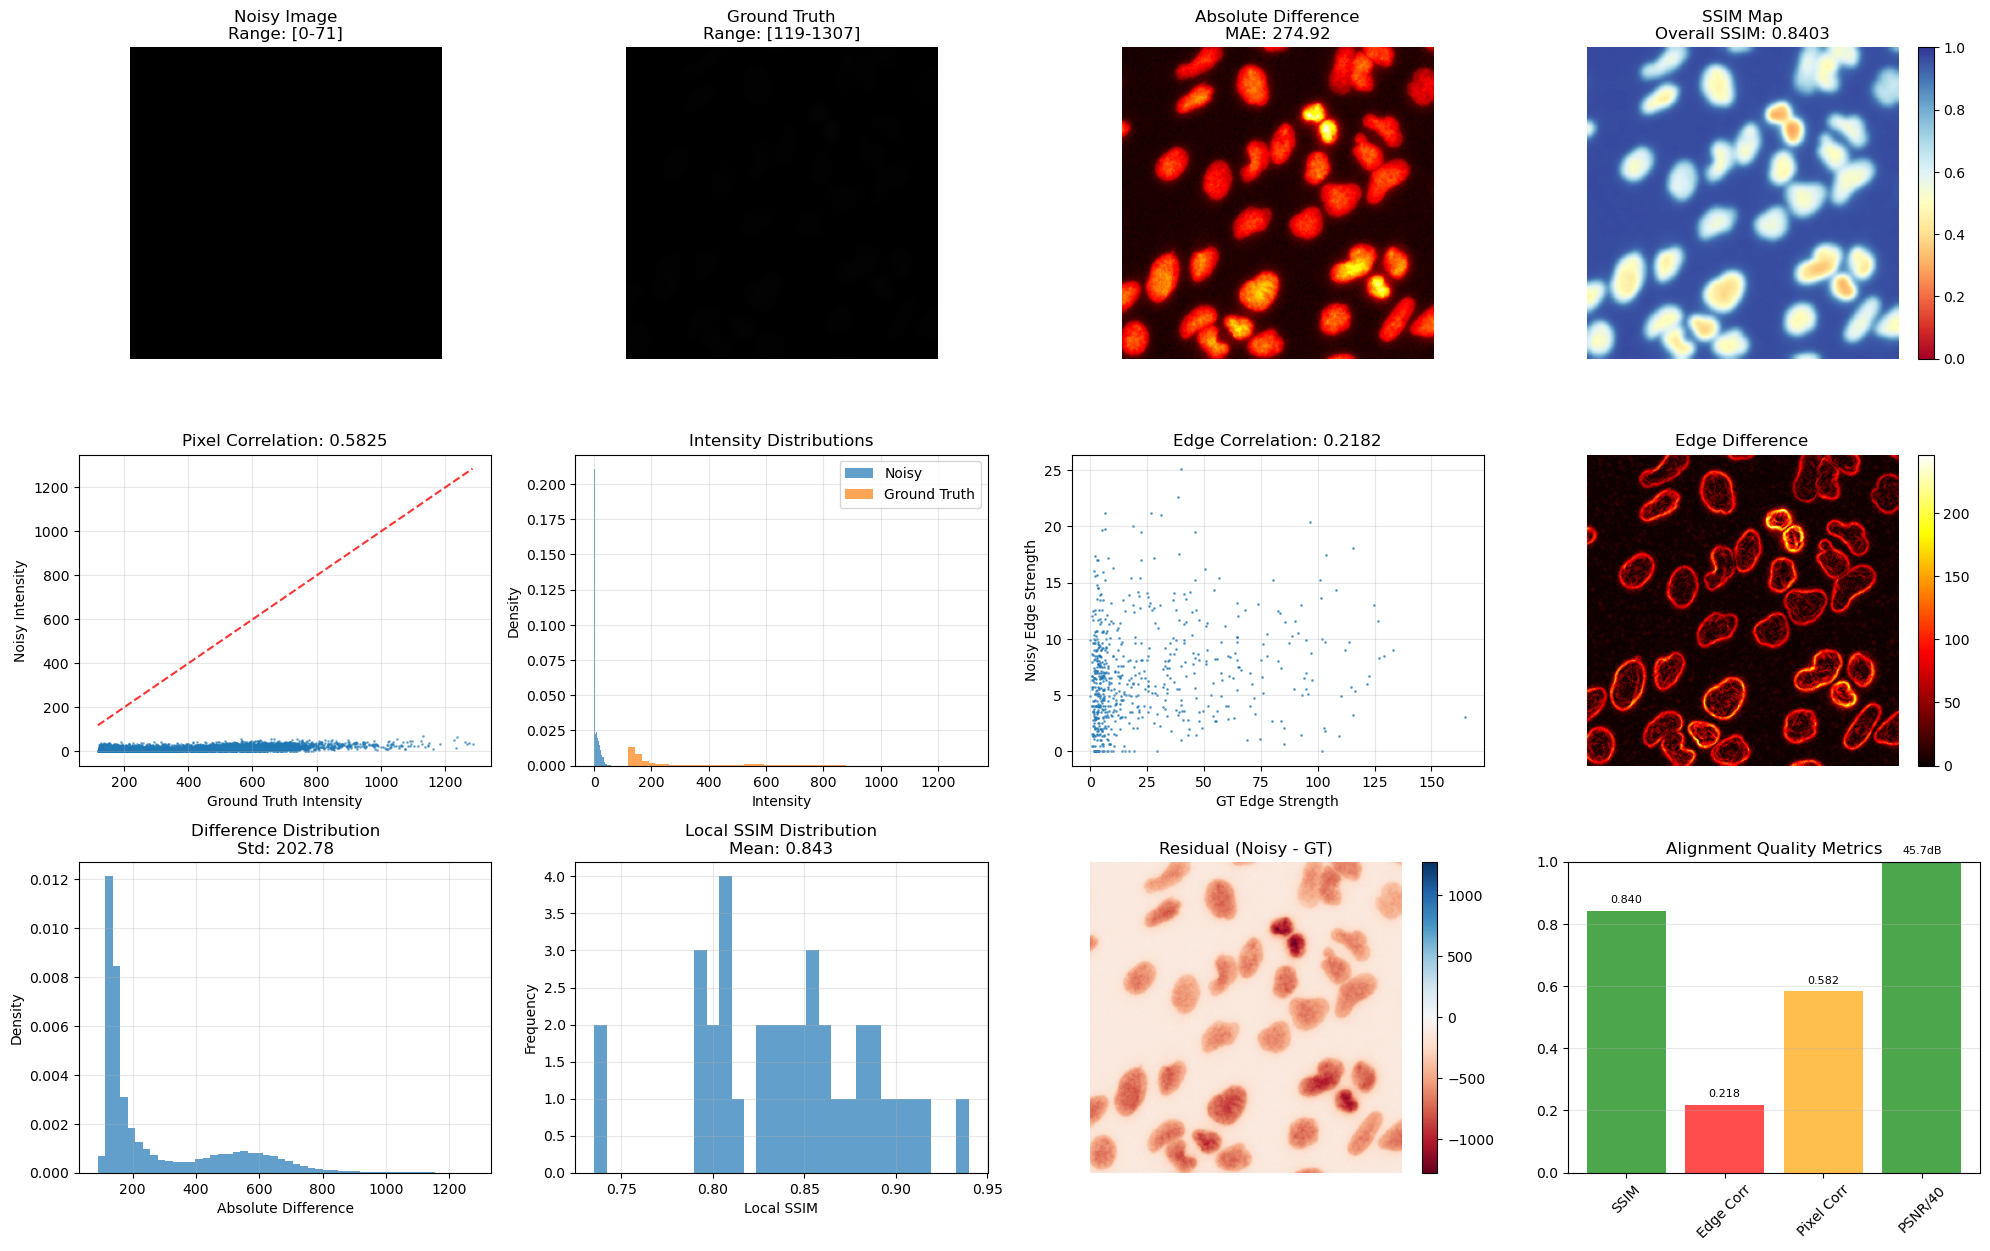

COMPREHENSIVE ALIGNMENT ANALYSIS RESULTS
OVERALL ALIGNMENT SCORE: 0.5470
----------------------------------------
SIMILARITY METRICS:
  SSIM:                    0.8403 ✓ GOOD
  Edge Correlation:        0.2182 ✗ POOR
  Pixel Correlation:       0.5825 ✗ POOR
  Local SSIM (mean±std):   0.843±0.045

ERROR METRICS:
  Mean Absolute Error:     274.92
  Mean Squared Error:      116701.98
  PSNR:                    45.66 dB ✓ GOOD

ALIGNMENT ASSESSMENT:
  ⚠ MODERATE alignment - Some misalignment detected

RECOMMENDATIONS:
  - Check for geometric transformations between images
  - Verify image registration
  - Check for intensity/exposure differences
  - Consider histogram matching if needed


In [20]:
for i in range(1000, 1001):
  noisy_path = filepath("noisy", i)
  gt_path = filepath("gt", i)
  if not os.path.exists(noisy_path) or not os.path.exists(gt_path):
    print(f"File not found: {noisy_path} or {gt_path}")

  # Load noisy image
  noisy_array, _ = load_tiff_pil(noisy_path)

  # Load GT image
  gt_array, _ = load_tiff_pil(gt_path)

  # check_alignment_tiff(noisy_array, gt_array)
  check_alignment_tiff_with_graphs(noisy_array, gt_array)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
import json
import warnings
warnings.filterwarnings('ignore')

class BatchTIFFAnalyzer:
    def __init__(self, noisy_dir, gt_dir, sample_size=50, n_workers=4):
        """
        Batch analyzer for large TIFF datasets

        Parameters:
        - noisy_dir: path to noisy images
        - gt_dir: path to ground truth images
        - sample_size: number of images to analyze in detail
        - n_workers: number of parallel workers
        """
        self.noisy_dir = Path(noisy_dir)
        self.gt_dir = Path(gt_dir)
        self.sample_size = sample_size
        self.n_workers = n_workers

        # Get file lists
        self.noisy_files = sorted([f for f in os.listdir(noisy_dir) if f.lower().endswith(('.tif', '.tiff'))])
        self.gt_files = sorted([f for f in os.listdir(gt_dir) if f.lower().endswith(('.tif', '.tiff'))])

        print(f"Found {len(self.noisy_files)} noisy and {len(self.gt_files)} GT images")

        self.results = []
        self.summary_stats = {}

    def quick_check_single_pair(self, idx):
        """Quick analysis of a single image pair"""
        try:
            noisy_path = self.noisy_dir / self.noisy_files[idx]
            gt_path = self.gt_dir / self.gt_files[idx]

            # Load images
            noisy_img = Image.open(noisy_path)
            gt_img = Image.open(gt_path)

            noisy_array = np.array(noisy_img)
            gt_array = np.array(gt_img)

            # Basic checks
            shape_match = noisy_array.shape == gt_array.shape
            mode_match = noisy_img.mode == gt_img.mode

            if not shape_match or not mode_match:
                return {
                    'idx': idx, 'filename': self.noisy_files[idx],
                    'shape_match': False, 'mode_match': False,
                    'noisy_shape': noisy_array.shape, 'gt_shape': gt_array.shape,
                    'error': 'Shape or mode mismatch'
                }

            # Determine data range
            if noisy_array.dtype == np.uint8:
                data_range = 255
            elif noisy_array.dtype == np.uint16:
                data_range = 65535
            else:
                data_range = max(noisy_array.max(), gt_array.max())

            # Quick metrics
            noisy_float = noisy_array.astype(float)
            gt_float = gt_array.astype(float)

            mae = np.mean(np.abs(noisy_float - gt_float))
            mse = np.mean((noisy_float - gt_float)**2)
            psnr = 20 * np.log10(data_range / np.sqrt(mse)) if mse > 0 else float('inf')

            # Quick SSIM (downsample for speed if image is large)
            if noisy_array.size > 1024*1024:  # If larger than 1MP, downsample
                scale = int(np.sqrt(noisy_array.size / (512*512)))
                if len(noisy_array.shape) == 3:
                    noisy_small = noisy_array[::scale, ::scale, :]
                    gt_small = gt_array[::scale, ::scale, :]
                    ssim_score = ssim(noisy_small, gt_small, channel_axis=2, data_range=data_range)
                else:
                    noisy_small = noisy_array[::scale, ::scale]
                    gt_small = gt_array[::scale, ::scale]
                    ssim_score = ssim(noisy_small, gt_small, data_range=data_range)
            else:
                if len(noisy_array.shape) == 3:
                    ssim_score = ssim(noisy_array, gt_array, channel_axis=2, data_range=data_range)
                else:
                    ssim_score = ssim(noisy_array, gt_array, data_range=data_range)

            # Pixel correlation (on sample for speed)
            sample_pixels = min(10000, noisy_array.size)
            indices = np.random.choice(noisy_array.size, sample_pixels, replace=False)
            pixel_corr = np.corrcoef(noisy_float.flatten()[indices], gt_float.flatten()[indices])[0,1]

            return {
                'idx': idx,
                'filename': self.noisy_files[idx],
                'shape': str(noisy_array.shape),  # Convert tuple to string
                'dtype': str(noisy_array.dtype),
                'mode': noisy_img.mode,
                'data_range': data_range,
                'shape_match': shape_match,
                'mode_match': mode_match,
                'mae': float(mae),
                'mse': float(mse),
                'psnr': float(psnr),
                'ssim': float(ssim_score),
                'pixel_correlation': float(pixel_corr),
                'noisy_min': float(noisy_array.min()),
                'noisy_max': float(noisy_array.max()),
                'noisy_mean': float(noisy_array.mean()),
                'gt_min': float(gt_array.min()),
                'gt_max': float(gt_array.max()),
                'gt_mean': float(gt_array.mean()),
                'error': None
            }

        except Exception as e:
            return {
                'idx': idx, 'filename': self.noisy_files[idx] if idx < len(self.noisy_files) else 'unknown',
                'error': str(e)
            }

    def run_batch_analysis(self):
        """Run analysis on entire dataset"""
        print(f"Running batch analysis on {len(self.noisy_files)} image pairs...")

        # Select sample indices
        if len(self.noisy_files) > self.sample_size:
            # Sample evenly across dataset + some random
            step = len(self.noisy_files) // (self.sample_size - 10)
            evenly_spaced = list(range(0, len(self.noisy_files), step))[:self.sample_size-10]
            random_indices = np.random.choice(len(self.noisy_files), 10, replace=False).tolist()
            sample_indices = sorted(set(evenly_spaced + random_indices))
        else:
            sample_indices = list(range(len(self.noisy_files)))

        print(f"Analyzing {len(sample_indices)} representative samples...")

        # Parallel processing
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            results = list(tqdm(
                executor.map(self.quick_check_single_pair, sample_indices),
                total=len(sample_indices),
                desc="Processing images"
            ))

        self.results = results
        self._compute_summary_stats()
        return results

    def _compute_summary_stats(self):
        """Compute summary statistics from results"""
        # Filter out error results
        valid_results = [r for r in self.results if r.get('error') is None]
        error_results = [r for r in self.results if r.get('error') is not None]

        if not valid_results:
            print("No valid results found!")
            return

        # Convert to DataFrame for easy stats
        df = pd.DataFrame(valid_results)

        metrics = ['mae', 'mse', 'psnr', 'ssim', 'pixel_correlation']
        stats = {}

        for metric in metrics:
            if metric in df.columns:
                stats[metric] = {
                    'mean': df[metric].mean(),
                    'std': df[metric].std(),
                    'min': df[metric].min(),
                    'max': df[metric].max(),
                    'median': df[metric].median(),
                    'q25': df[metric].quantile(0.25),
                    'q75': df[metric].quantile(0.75)
                }

        self.summary_stats = {
            'total_pairs': len(self.noisy_files),
            'analyzed_pairs': len(valid_results),
            'error_pairs': len(error_results),
            'shape_mismatches': sum(1 for r in valid_results if not r.get('shape_match', True)),
            'mode_mismatches': sum(1 for r in valid_results if not r.get('mode_match', True)),
            'metrics': stats,
            'dtypes': df['dtype'].value_counts().to_dict() if 'dtype' in df.columns else {},
            'modes': df['mode'].value_counts().to_dict() if 'mode' in df.columns else {},
            'shapes': {str(k): v for k, v in df['shape'].value_counts().to_dict().items()} if 'shape' in df.columns else {}
        }

        # Quality assessment
        if 'ssim' in stats:
            good_alignment = sum(1 for r in valid_results if r.get('ssim', 0) > 0.7)
            moderate_alignment = sum(1 for r in valid_results if 0.4 < r.get('ssim', 0) <= 0.7)
            poor_alignment = sum(1 for r in valid_results if r.get('ssim', 0) <= 0.4)

            self.summary_stats['quality_assessment'] = {
                'good_alignment': good_alignment,
                'moderate_alignment': moderate_alignment,
                'poor_alignment': poor_alignment,
                'good_percentage': good_alignment / len(valid_results) * 100
            }

    def generate_report(self, save_path=None):
        """Generate comprehensive analysis report"""

        if not self.summary_stats:
            print("No analysis results available. Run run_batch_analysis() first.")
            return

        # Create comprehensive plots
        fig = plt.figure(figsize=(20, 24))

        # Filter valid results for plotting
        valid_results = [r for r in self.results if r.get('error') is None]
        df = pd.DataFrame(valid_results)

        # Plot 1: SSIM Distribution
        ax1 = plt.subplot(4, 3, 1)
        if 'ssim' in df.columns:
            plt.hist(df['ssim'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            plt.axvline(df['ssim'].mean(), color='red', linestyle='--', label=f'Mean: {df["ssim"].mean():.3f}')
            plt.axvline(0.7, color='green', linestyle='--', label='Good threshold')
            plt.axvline(0.4, color='orange', linestyle='--', label='Poor threshold')
            plt.xlabel('SSIM Score')
            plt.ylabel('Frequency')
            plt.title('SSIM Distribution Across Dataset')
            plt.legend()
            plt.grid(True, alpha=0.3)

        # Plot 2: PSNR Distribution
        ax2 = plt.subplot(4, 3, 2)
        if 'psnr' in df.columns:
            psnr_vals = df['psnr'][df['psnr'] != float('inf')]
            plt.hist(psnr_vals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
            plt.axvline(psnr_vals.mean(), color='red', linestyle='--', label=f'Mean: {psnr_vals.mean():.1f} dB')
            plt.axvline(30, color='green', linestyle='--', label='Good threshold')
            plt.axvline(20, color='orange', linestyle='--', label='Poor threshold')
            plt.xlabel('PSNR (dB)')
            plt.ylabel('Frequency')
            plt.title('PSNR Distribution')
            plt.legend()
            plt.grid(True, alpha=0.3)

        # Plot 3: Pixel Correlation Distribution
        ax3 = plt.subplot(4, 3, 3)
        if 'pixel_correlation' in df.columns:
            plt.hist(df['pixel_correlation'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
            plt.axvline(df['pixel_correlation'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["pixel_correlation"].mean():.3f}')
            plt.xlabel('Pixel Correlation')
            plt.ylabel('Frequency')
            plt.title('Pixel Correlation Distribution')
            plt.legend()
            plt.grid(True, alpha=0.3)

        # Plot 4: Quality Assessment Pie Chart
        ax4 = plt.subplot(4, 3, 4)
        if 'quality_assessment' in self.summary_stats:
            qa = self.summary_stats['quality_assessment']
            labels = ['Good (SSIM > 0.7)', 'Moderate (0.4-0.7)', 'Poor (< 0.4)']
            sizes = [qa['good_alignment'], qa['moderate_alignment'], qa['poor_alignment']]
            colors = ['green', 'orange', 'red']
            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            plt.title('Dataset Quality Distribution')

        # Plot 5: SSIM vs PSNR Scatter
        ax5 = plt.subplot(4, 3, 5)
        if 'ssim' in df.columns and 'psnr' in df.columns:
            psnr_clean = df['psnr'][df['psnr'] != float('inf')]
            ssim_clean = df['ssim'][df['psnr'] != float('inf')]
            plt.scatter(ssim_clean, psnr_clean, alpha=0.6, s=20)
            plt.xlabel('SSIM Score')
            plt.ylabel('PSNR (dB)')
            plt.title('SSIM vs PSNR Correlation')
            plt.grid(True, alpha=0.3)

            # Add correlation coefficient
            corr_coef = np.corrcoef(ssim_clean, psnr_clean)[0,1]
            plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}',
                    transform=ax5.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

        # Plot 6: MAE Distribution
        ax6 = plt.subplot(4, 3, 6)
        if 'mae' in df.columns:
            plt.hist(df['mae'], bins=30, alpha=0.7, color='gold', edgecolor='black')
            plt.axvline(df['mae'].mean(), color='red', linestyle='--', label=f'Mean: {df["mae"].mean():.1f}')
            plt.xlabel('Mean Absolute Error')
            plt.ylabel('Frequency')
            plt.title('MAE Distribution')
            plt.legend()
            plt.grid(True, alpha=0.3)

        # Plot 7: Data Type and Mode Summary
        ax7 = plt.subplot(4, 3, 7)
        if 'dtypes' in self.summary_stats:
            dtypes = self.summary_stats['dtypes']
            plt.bar(dtypes.keys(), dtypes.values(), color='plum', alpha=0.7)
            plt.xlabel('Data Type')
            plt.ylabel('Count')
            plt.title('Data Type Distribution')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3, axis='y')

        # Plot 8: Image Intensity Statistics
        ax8 = plt.subplot(4, 3, 8)
        if 'noisy_mean' in df.columns and 'gt_mean' in df.columns:
            plt.scatter(df['gt_mean'], df['noisy_mean'], alpha=0.6, s=20)
            min_val = min(df['gt_mean'].min(), df['noisy_mean'].min())
            max_val = max(df['gt_mean'].max(), df['noisy_mean'].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
            plt.xlabel('GT Mean Intensity')
            plt.ylabel('Noisy Mean Intensity')
            plt.title('Intensity Relationship')
            plt.grid(True, alpha=0.3)

        # Plot 9: Error Analysis
        ax9 = plt.subplot(4, 3, 9)
        error_count = self.summary_stats.get('error_pairs', 0)
        mismatch_count = self.summary_stats.get('shape_mismatches', 0) + self.summary_stats.get('mode_mismatches', 0)
        valid_count = self.summary_stats.get('analyzed_pairs', 0)

        categories = ['Valid Pairs', 'Mismatches', 'Errors']
        counts = [valid_count, mismatch_count, error_count]
        colors = ['green', 'orange', 'red']

        plt.bar(categories, counts, color=colors, alpha=0.7)
        plt.ylabel('Count')
        plt.title('Dataset Health Summary')
        plt.grid(True, alpha=0.3, axis='y')

        # Add count labels on bars
        for i, count in enumerate(counts):
            plt.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom')

        # Plot 10-12: Metric box plots
        metrics_to_plot = ['ssim', 'psnr', 'pixel_correlation']
        for i, metric in enumerate(metrics_to_plot):
            ax = plt.subplot(4, 3, 10 + i)
            if metric in df.columns:
                if metric == 'psnr':
                    data = df[metric][df[metric] != float('inf')]
                else:
                    data = df[metric]
                plt.boxplot(data, labels=[metric.upper()])
                plt.ylabel('Value')
                plt.title(f'{metric.upper()} Distribution')
                plt.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Report saved to {save_path}")

        plt.show()

        # Print text summary
        self.print_summary()

    def print_summary(self):
        """Print detailed text summary"""
        print("\n" + "="*80)
        print("BATCH TIFF DATASET ANALYSIS SUMMARY")
        print("="*80)

        stats = self.summary_stats

        print(f"📊 DATASET OVERVIEW:")
        print(f"   Total image pairs: {stats['total_pairs']:,}")
        print(f"   Analyzed samples: {stats['analyzed_pairs']:,}")
        print(f"   Error pairs: {stats['error_pairs']}")
        print(f"   Shape mismatches: {stats['shape_mismatches']}")
        print(f"   Mode mismatches: {stats['mode_mismatches']}")

        if 'quality_assessment' in stats:
            qa = stats['quality_assessment']
            print(f"\n🎯 QUALITY ASSESSMENT:")
            print(f"   Good alignment (SSIM > 0.7): {qa['good_alignment']} ({qa['good_percentage']:.1f}%)")
            print(f"   Moderate alignment (0.4-0.7): {qa['moderate_alignment']}")
            print(f"   Poor alignment (< 0.4): {qa['poor_alignment']}")

        print(f"\n📈 ALIGNMENT METRICS:")
        metrics = stats.get('metrics', {})
        for metric_name, metric_stats in metrics.items():
            print(f"   {metric_name.upper()}:")
            print(f"     Mean ± Std: {metric_stats['mean']:.4f} ± {metric_stats['std']:.4f}")
            print(f"     Range: [{metric_stats['min']:.4f}, {metric_stats['max']:.4f}]")
            print(f"     Median (Q25-Q75): {metric_stats['median']:.4f} ({metric_stats['q25']:.4f}-{metric_stats['q75']:.4f})")

        print(f"\n💾 DATA CHARACTERISTICS:")
        print(f"   Data types: {stats.get('dtypes', {})}")
        print(f"   Image modes: {stats.get('modes', {})}")

        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        if 'quality_assessment' in stats:
            good_pct = stats['quality_assessment']['good_percentage']
            if good_pct > 90:
                print("   ✅ Excellent dataset quality - ready for training!")
            elif good_pct > 70:
                print("   ⚠️  Good dataset quality - minor issues present")
                print("   → Consider reviewing pairs with low SSIM scores")
            else:
                print("   ❌ Dataset quality issues detected")
                print("   → Review alignment process and image pairs")
                print("   → Consider filtering out poor quality pairs")

        if stats.get('error_pairs', 0) > 0:
            print("   → Fix file loading errors")

        if stats.get('shape_mismatches', 0) > 0 or stats.get('mode_mismatches', 0) > 0:
            print("   → Ensure all image pairs have matching dimensions and modes")

        print("="*80)

    def save_detailed_results(self, filepath):
        """Save detailed results to JSON file"""

        def convert_for_json(obj):
            """Convert numpy types and tuples to JSON-serializable types"""
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, tuple):
                return str(obj)
            elif isinstance(obj, (np.integer, np.floating)):
                return float(obj)
            elif isinstance(obj, np.bool_):
                return bool(obj)
            return obj

        # Deep convert all values
        def deep_convert(data):
            if isinstance(data, dict):
                return {str(k): deep_convert(v) for k, v in data.items()}
            elif isinstance(data, list):
                return [deep_convert(item) for item in data]
            else:
                return convert_for_json(data)

        output_data = {
            'summary_stats': deep_convert(self.summary_stats),
            'detailed_results': deep_convert(self.results),
            'analysis_params': {
                'sample_size': self.sample_size,
                'total_files': len(self.noisy_files),
                'noisy_dir': str(self.noisy_dir),
                'gt_dir': str(self.gt_dir)
            }
        }

        with open(filepath, 'w') as f:
            json.dump(output_data, f, indent=2)

        print(f"Detailed results saved to {filepath}")

    def get_problematic_pairs(self, ssim_threshold=0.4):
        """Return list of problematic image pairs for manual review"""
        valid_results = [r for r in self.results if r.get('error') is None]
        problematic = [r for r in valid_results if r.get('ssim', 1.0) < ssim_threshold]

        print(f"\nFound {len(problematic)} pairs with SSIM < {ssim_threshold}:")
        for result in problematic:
            print(f"  {result['filename']}: SSIM={result['ssim']:.3f}, PSNR={result['psnr']:.1f}dB")

        return problematic

# Usage example:
def analyze_large_dataset(noisy_dir, gt_dir, sample_size=100):
    """
    Main function to analyze large TIFF datasets

    Usage:
    analyze_large_dataset('/path/to/noisy_tiffs', '/path/to/gt_tiffs', sample_size=100)
    """

    # Initialize analyzer
    analyzer = BatchTIFFAnalyzer(noisy_dir, gt_dir, sample_size=sample_size, n_workers=8)

    # Run analysis
    results = analyzer.run_batch_analysis()

    # Generate comprehensive report
    analyzer.generate_report(save_path='dataset_analysis_report.png')

    # Save detailed results
    analyzer.save_detailed_results('detailed_analysis_results.json')

    # Get problematic pairs for manual review
    problematic = analyzer.get_problematic_pairs(ssim_threshold=0.4)

    return analyzer, results

# Example usage:
# analyzer, results = analyze_large_dataset(
#     noisy_dir='/path/to/noisy_images',
#     gt_dir='/path/to/ground_truth_images',
#     sample_size=100  # Analyze 100 representative samples
# )

In [22]:
# analyzer, results = analyze_large_dataset(
#     noisy_dir='./small_images/noisy/',
#     gt_dir='./small_images/gt/',
#     sample_size=2000  # Analyze 100 representative samples
# )

In [23]:
# analyzer, results = analyze_large_dataset(
#     noisy_dir='./large_images/noisy/',
#     gt_dir='./large_images/gt/',
#     sample_size=15  # Analyze 100 representative samples
# )

# Models


## CNN Model

In [24]:
import torch
import torch.nn as nn
import numpy as np
import cv2

In [25]:
print(torch.cuda.is_available())      # should be True
print(torch.cuda.current_device())    # should be 0
print(torch.cuda.get_device_name(0))  # should show your GPU name

True
0
NVIDIA GeForce RTX 5060 Laptop GPU


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [27]:
def display_image(image_array, title="Image", figsize=(8, 6), cmap=None):
    """
    Display a numpy array as an image.

    Parameters:
    -----------
    image_array : numpy.ndarray
        The image array to display. Can be:
        - 2D array (grayscale): shape (H, W)
        - 3D array (color): shape (H, W, 3) for RGB or (H, W, 4) for RGBA
    title : str, optional
        Title for the image plot (default: "Image")
    figsize : tuple, optional
        Figure size as (width, height) in inches (default: (8, 6))
    cmap : str, optional
        Colormap for grayscale images (default: None, uses 'gray' for 2D arrays)

    Returns:
    --------
    None
        Displays the image using matplotlib
    """

    # Create figure and axis
    plt.figure(figsize=figsize)

    # Determine if image is grayscale or color
    if len(image_array.shape) == 2:
        # Grayscale image
        if cmap is None:
            cmap = 'gray'
        plt.imshow(image_array, cmap=cmap)
    elif len(image_array.shape) == 3:
        # Color image
        if image_array.shape[2] == 1:
            # Single channel, squeeze and display as grayscale
            plt.imshow(image_array.squeeze(), cmap='gray' if cmap is None else cmap)
        else:
            # RGB or RGBA image
            plt.imshow(image_array)
    else:
        raise ValueError(f"Invalid image shape: {image_array.shape}. Expected 2D or 3D array.")

    # Add title and remove axes
    plt.title(title)
    plt.axis('off')  # Remove axis ticks and labels

    # Display the image
    plt.tight_layout()
    plt.show()

In [28]:
noisy_torch = torch.from_numpy(noisy_array).float().unsqueeze(0).unsqueeze(0).to(device)
gt_torch = torch.from_numpy(gt_array).float().unsqueeze(0).unsqueeze(0).to(device)

print(noisy_torch.shape)
print(gt_torch.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [29]:
class Convolution_NN(nn.Module):
  def __init__(self, kernel_size):
    super(Convolution_NN, self).__init__()
    self.conv1 = nn.Conv2d(1, 1, kernel_size, padding=(int(kernel_size/2),int(kernel_size/2)), bias = False)
    # self.conv1.weight.data.fill_(1.0 / (kernel_size * kernel_size))

  def forward(self, x):
    x = self.conv1(x)
    return x

conv_fixed_kernel = Convolution_NN(31).to(device)
conv_out_torch = conv_fixed_kernel(noisy_torch)
conv_out_np = np.squeeze(conv_out_torch.detach().cpu().numpy())


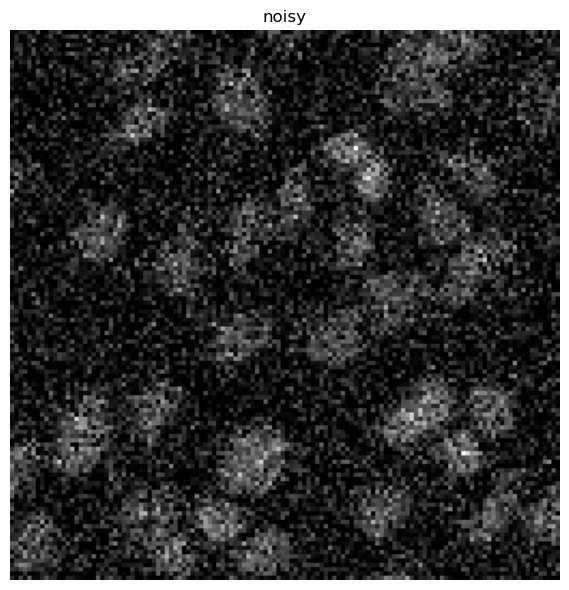

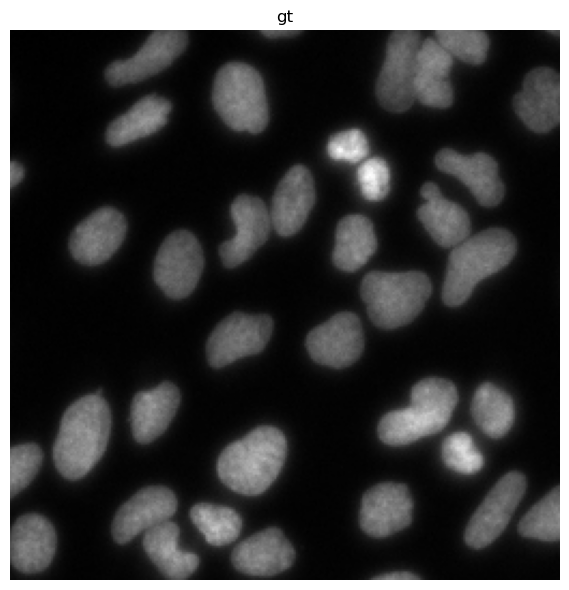

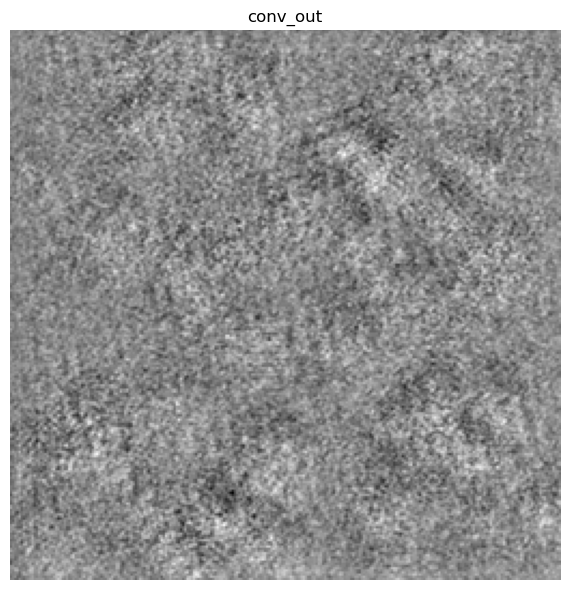

In [30]:
display_image(noisy_array, 'noisy')
display_image(gt_array, 'gt')
display_image( conv_out_np, 'conv_out')

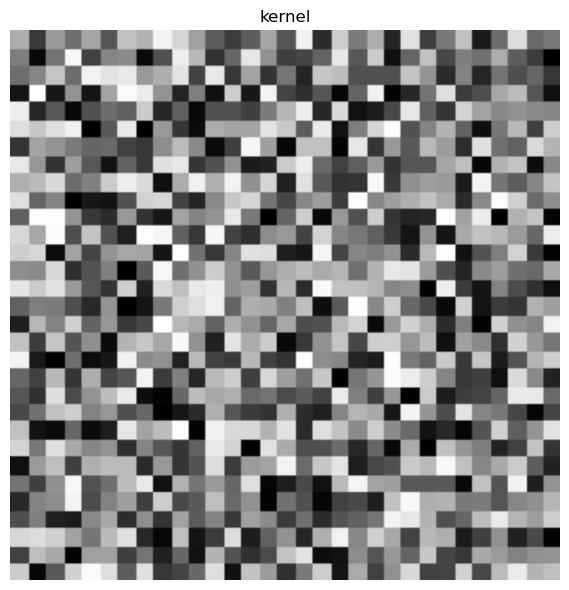

In [31]:
kernel_torch = list(conv_fixed_kernel.parameters())[0]
kernel_np = cv2.resize(np.squeeze(kernel_torch.detach().to("cpu").numpy()), (200, 200), interpolation=0)
display_image(kernel_np, 'kernel')

In [36]:
# conv_trained_kernel = Convolution_NN(31)
# loss_function = nn.MSELoss()
# true_torch = torch.from_numpy(gt_array).float().unsqueeze(0).unsqueeze(0)
# optimizer = torch.optim.Adam(conv_trained_kernel.parameters(), lr=0.003)

# # Store loss values
# report = []

# # Training loop
# num_epochs = 500
# for epoch in range(num_epochs):
#     # Forward pass
#     output = conv_trained_kernel(noisy_torch)
#     loss = loss_function(output, true_torch)

#     # Backward pass
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Save loss
#     report.append(loss.item())

#     # Print progress every 50 epochs
#     if (epoch + 1) % 50 == 0 or epoch == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# # Plot the loss curve
# plt.figure(figsize=(8, 5))
# plt.plot(report, label="Training Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss Curve During Training")
# plt.legend()
# plt.grid(True)
# plt.show()

# cnn_output = np.squeeze(output.detach().numpy())
# cv2.putText(cnn_output, "Ep %d" % epoch, (2,30), 0, 1, int(np.max(cnn_output)+1), 1, cv2.LINE_AA)
# display_image(cnn_output, 'cnn_output')

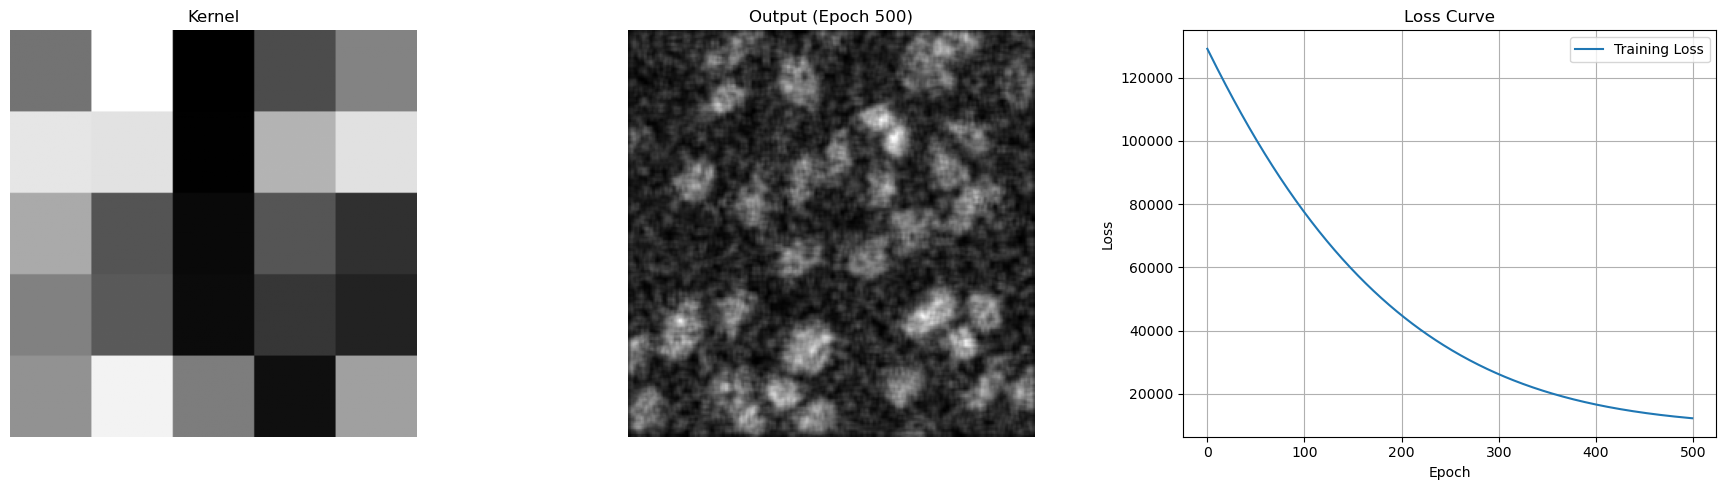

Epoch [500/500], Loss: 12260.7510


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import numpy as np
import torch
import torch.nn as nn

conv_trained_kernel = Convolution_NN(31).to(device)
loss_function = nn.MSELoss()
true_torch = torch.from_numpy(gt_array).float().unsqueeze(0).unsqueeze(0).to(device)
optimizer = torch.optim.Adam(conv_trained_kernel.parameters(), lr=0.003)

# Store loss values
report = []

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    output = conv_trained_kernel(noisy_torch)
    loss = loss_function(output, true_torch)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save loss
    report.append(loss.item())

    # --- Visualization part ---
    clear_output(wait=True)   # clears previous cell output

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Kernel visualization
    kernel_torch = list(conv_trained_kernel.parameters())[0]
    kernel_np = cv2.resize(np.squeeze(kernel_torch.detach().to("cpu").numpy()), (200, 200), interpolation=0)
    axs[0].imshow(kernel_np, cmap='gray')
    axs[0].set_title("Kernel")
    axs[0].axis("off")

    # CNN output visualization
    cnn_output = np.squeeze(output.detach().to("cpu").numpy())
    axs[1].imshow(cnn_output, cmap='gray')
    axs[1].set_title(f"Output (Epoch {epoch+1})")
    axs[1].axis("off")

    # Live loss curve
    axs[2].plot(report, label="Training Loss")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Loss")
    axs[2].set_title("Loss Curve")
    axs[2].grid(True)
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


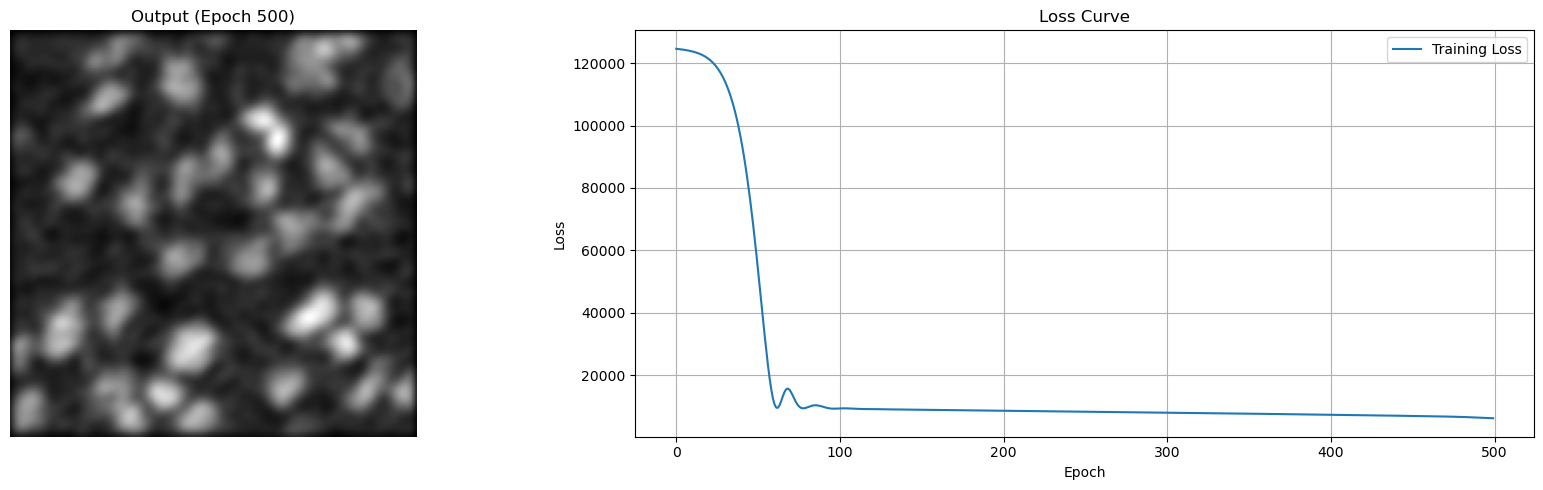

Epoch [500/500], Loss: 6161.1982


In [41]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=(3,3)),
            nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)),
            nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)),
            nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)),
            nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding=(3,3)),
            nn.PReLU()
        )

    def forward(self, x):
        return self.CNN(x)

cnn_to_train = CNN().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_to_train.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

# Store loss values
report = []

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    output = cnn_to_train(noisy_torch)
    loss = loss_function(output, true_torch)
    scheduler.step(loss)  # Adjust learning rate based on loss
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save loss
    report.append(loss.item())

    # --- Visualization part ---
    clear_output(wait=True)   # clears previous cell output

    fig, axs = plt.subplots(1, 2, figsize=(18, 5))


    # CNN output visualization
    cnn_output = np.squeeze(output.detach().to("cpu").numpy())
    axs[0].imshow(cnn_output, cmap='gray')
    axs[0].set_title(f"Output (Epoch {epoch+1})")
    axs[0].axis("off")

    # Live loss curve
    axs[1].plot(report, label="Training Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].set_title("Loss Curve")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


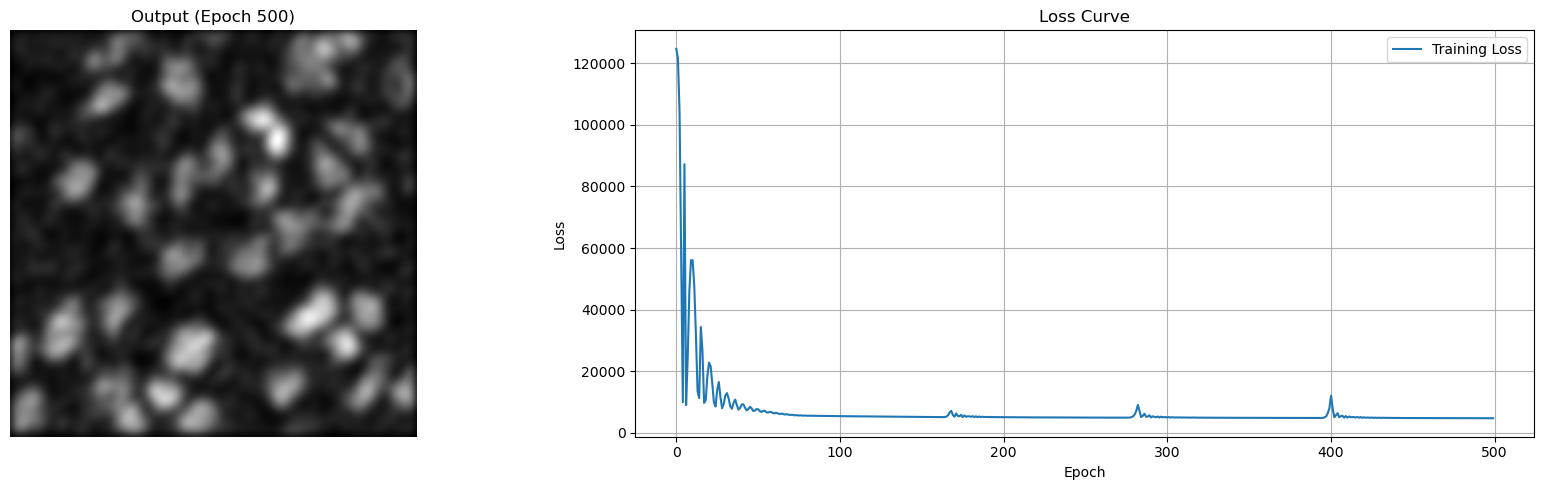